# OLS vs. Spatial Adapter Comparison with Tuning Parameter Selection

This notebook implements a comprehensive comparison between:
1. **OLS (Ordinary Least Squares)** - Linear baseline
2. **Unregularized Spatial Adapter** - Neural spatial model without regularization
3. **Regularized Spatial Adapter** - Neural spatial model with optimized tau1, tau2 parameters

The experiment uses Optuna for hyperparameter optimization and evaluates performance across multiple random seeds.

my work: ols 換成 TFT 然後執行模擬

In [9]:
# Import required libraries
import csv
import math
from pathlib import Path

import numpy as np
import optuna
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from optuna.pruners import MedianPruner
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from typing import Tuple, Dict, Any
import pandas as pd

from geospatial_neural_adapter.cpp_extensions import estimate_covariance
from geospatial_neural_adapter.utils.experiment import log_covariance_and_basis
from geospatial_neural_adapter.utils import (
    ModelCache,
    clear_gpu_memory,
    compute_ols_coefficients,
    create_experiment_config,
    create_fresh_models,
    predict_ols,
    print_experiment_summary,
    get_device_info,
)
from geospatial_neural_adapter.models.spatial_basis_learner import SpatialBasisLearner
from geospatial_neural_adapter.models.spatial_neural_adapter import SpatialNeuralAdapter
from geospatial_neural_adapter.models.trend_model import TrendModel
from geospatial_neural_adapter.data.generators import generate_time_synthetic_data
from geospatial_neural_adapter.data.preprocessing import prepare_all_with_scaling, denormalize_predictions
from geospatial_neural_adapter.metrics import compute_metrics

from darts import TimeSeries
from darts.models import TFTModel

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports successful!")

✅ All imports successful!


## 1. Parameter Configuration and Setup

In [10]:
# Experiment Configuration
EXPERIMENT_CONFIG = {
    'seed': 42,
    'n_time_steps': 1024,
    'n_locations': 512,
    'noise_std': 4.0,
    'eigenvalue': 16.0,
    'latent_dim': 1,
    'ckpt_dir': "admm_bcd_ckpts",
}

# Spatial Neural Adapter Configuration using dataclasses
from geospatial_neural_adapter.models.spatial_neural_adapter import (
    SpatialNeuralAdapterConfig, ADMMConfig, TrainingConfig, BasisConfig
)

# ADMM Configuration
admm_config = ADMMConfig(
    rho=1.0,  # Base ADMM penalty parameter
    dual_momentum=0.2,  # Dual variable momentum
    max_iters=3000,  # Maximum ADMM iterations
    min_outer=20,  # Minimum outer iterations before convergence check
    tol=1e-4,  # Convergence tolerance
)

# Training Configuration
training_config = TrainingConfig(
    lr_mu=1e-2,  # Learning rate for trend parameters
    batch_size=64,  # Batch size for theta step
    pretrain_epochs=5,  # Default pretraining epochs
    use_mixed_precision=False,  # Whether to use mixed precision
)

# Basis Configuration
basis_config = BasisConfig(
    phi_every=5,  # Update basis every N iterations
    phi_freeze=200,  # Stop updating basis after N iterations
    matrix_reg=1e-6,  # Matrix regularization for basis update
    irl1_max_iters=10,  # IRL₁ maximum iterations
    irl1_eps=1e-6,  # IRL₁ epsilon
    irl1_tol=5e-4,  # IRL₁ inner tolerance
)

# Complete Spatial Neural Adapter Configuration
SPATIAL_CONFIG = SpatialNeuralAdapterConfig(
    admm=admm_config,
    training=training_config,
    basis=basis_config
)

# Legacy config dict for backward compatibility (if needed)
CFG = SPATIAL_CONFIG.to_dict()
CFG.update(EXPERIMENT_CONFIG)

# Set random seed
torch.manual_seed(EXPERIMENT_CONFIG["seed"])
Path(EXPERIMENT_CONFIG["ckpt_dir"]).mkdir(exist_ok=True)

# Device setup
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_info = get_device_info()
print(f"Using {device_info['device'].upper()}: {device_info['device_name']}")
if device_info['device'] == 'cuda':
    print(f"   Memory: {device_info['memory_gb']} GB")

# Print configuration summary
print("\n=== Experiment Configuration ===")
for key, value in EXPERIMENT_CONFIG.items():
    print(f"{key}: {value}")

print("\n=== Spatial Neural Adapter Configuration ===")
SPATIAL_CONFIG.log_config()

2025-08-10 11:33:36,198 - spatial_neural_adapter - INFO - SpatialNeuralAdapterConfig:
2025-08-10 11:33:36,198 - spatial_neural_adapter - INFO -   ADMM Config:
2025-08-10 11:33:36,199 - spatial_neural_adapter - INFO -     rho: 1.0
2025-08-10 11:33:36,199 - spatial_neural_adapter - INFO -     dual_momentum: 0.2
2025-08-10 11:33:36,200 - spatial_neural_adapter - INFO -     max_iters: 3000
2025-08-10 11:33:36,201 - spatial_neural_adapter - INFO -     min_outer: 20
2025-08-10 11:33:36,201 - spatial_neural_adapter - INFO -     tol: 0.0001
2025-08-10 11:33:36,202 - spatial_neural_adapter - INFO -   Training Config:
2025-08-10 11:33:36,202 - spatial_neural_adapter - INFO -     lr_mu: 0.01
2025-08-10 11:33:36,202 - spatial_neural_adapter - INFO -     batch_size: 64
2025-08-10 11:33:36,203 - spatial_neural_adapter - INFO -     pretrain_epochs: 5
2025-08-10 11:33:36,203 - spatial_neural_adapter - INFO -     use_mixed_precision: False
2025-08-10 11:33:36,203 - spatial_neural_adapter - INFO -   Bas

Using CUDA: NVIDIA GeForce RTX 4060 Laptop GPU
   Memory: 8.6 GB

=== Experiment Configuration ===
seed: 42
n_time_steps: 1024
n_locations: 512
noise_std: 4.0
eigenvalue: 16.0
latent_dim: 1
ckpt_dir: admm_bcd_ckpts

=== Spatial Neural Adapter Configuration ===


## 2. Initialize Utilities
 目前減少跑的次數 確認完之後要跑完整的

In [11]:
# Initialize model cache for hyperparameter optimization
cache = ModelCache()

# Create experiment configuration
EXPERIMENT_TRIALS_CONFIG = create_experiment_config(
    n_trials_per_seed=5 if torch.cuda.is_available() else 50,
    n_dataset_seeds=2,
    seed_range_start=1,
    seed_range_end=3,
)

print_experiment_summary(EXPERIMENT_TRIALS_CONFIG)
print("Utilities initialized successfully!")

Experiment Configuration:
  Trials per seed: 5
  Dataset seeds: 1 to 2
  Total experiments: 10
  Device: GPU
Utilities initialized successfully!


## 3. Data Generation and Preprocessing

In [12]:
# Generate synthetic data with meaningful correlations
print("Generating correlated synthetic data...")

locs = np.linspace(-3, 3, CFG["n_locations"])
cat_features, cont_features, targets = generate_time_synthetic_data(
    locs=locs,
    n_time_steps=CFG["n_time_steps"],
    noise_std=CFG["noise_std"],
    eigenvalue=CFG["eigenvalue"],
    eta_rho=0.8,
    f_rho=0.6,
    global_mean=50.0,
    feature_noise_std=0.1,
    non_linear_strength=0.2,
    seed=CFG["seed"]
)

# Prepare datasets with scaling
train_dataset, val_dataset, test_dataset, preprocessor = prepare_all_with_scaling(
    cat_features=cat_features,
    cont_features=cont_features,
    targets=targets,
    train_ratio=0.7,
    val_ratio=0.15,
    feature_scaler_type="standard",
    target_scaler_type="standard",
    fit_on_train_only=True
)
train_loader = DataLoader(train_dataset, batch_size=CFG["batch_size"], shuffle=True)

# Extract tensors
_, train_X, train_y = train_dataset.tensors
_, val_X, val_y = val_dataset.tensors
_, test_X, test_y = test_dataset.tensors

p_dim = train_X.shape[-1]

print(f"Data shapes: {cont_features.shape}, {targets.shape}")
print(f"Original targets - Mean: {targets.mean():.2f}, Std: {targets.std():.2f}")
print(f"Original targets - Range: {targets.min():.2f} to {targets.max():.2f}")
print(f"Feature dimension: {p_dim}")

Generating correlated synthetic data...
Data shapes: (1024, 512, 3), (1024, 512)
Original targets - Mean: 50.95, Std: 4.22
Original targets - Range: 31.31 to 72.22
Feature dimension: 3


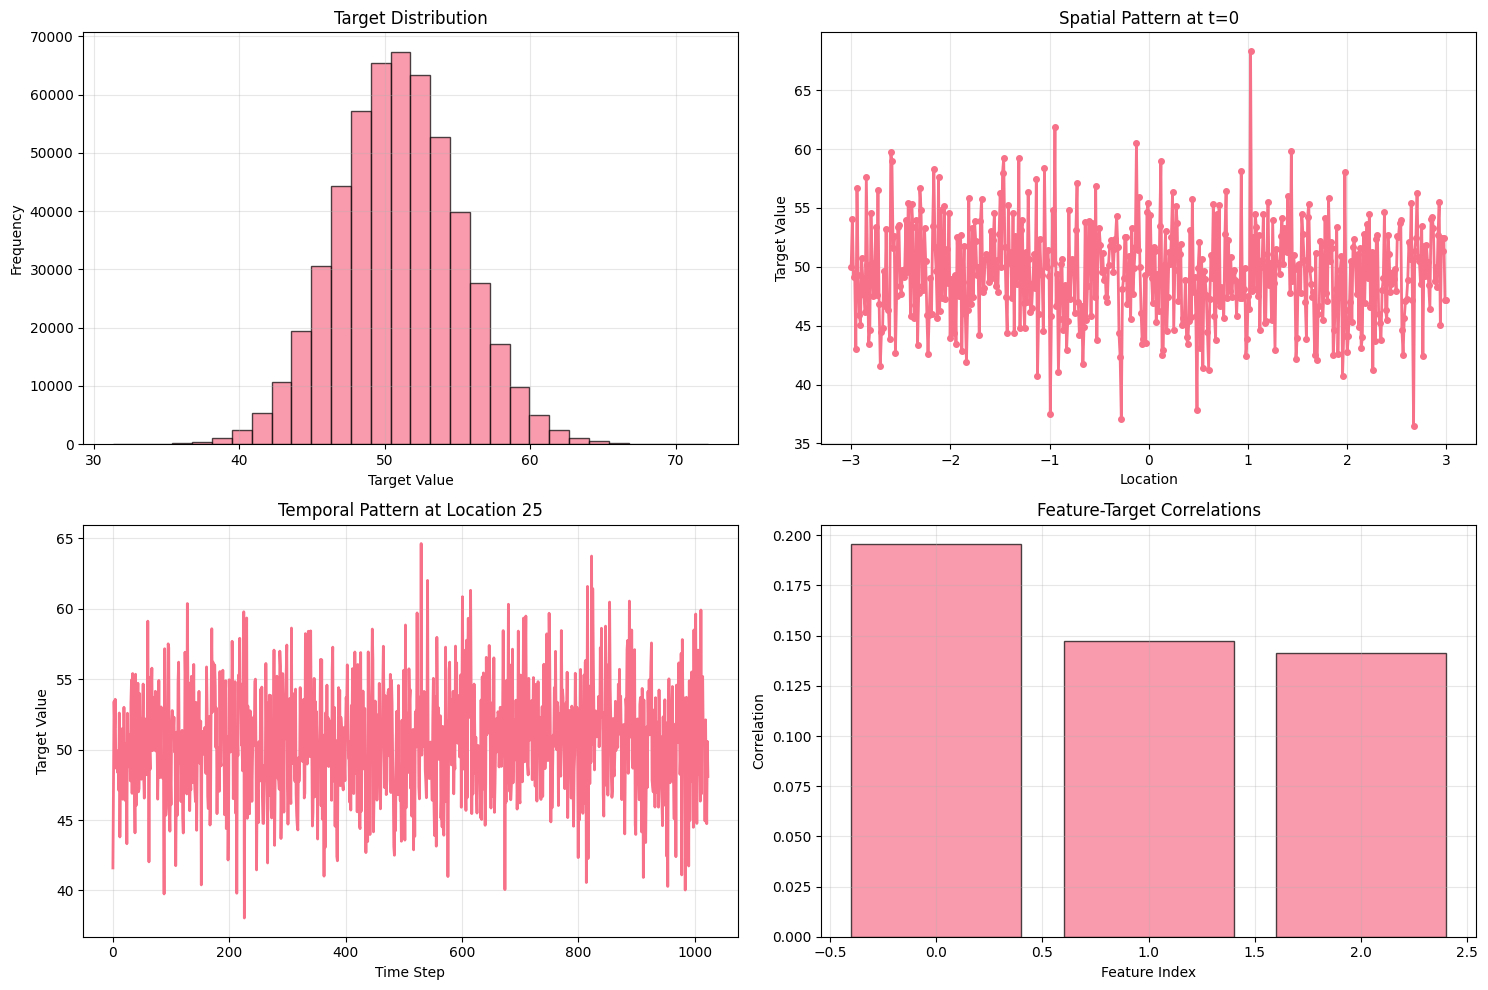

In [13]:
# Visualize data characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Target distribution
axes[0, 0].hist(targets.flatten(), bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Target Distribution')
axes[0, 0].set_xlabel('Target Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Spatial pattern at first time step
axes[0, 1].plot(locs, targets[0, :], 'o-', linewidth=2, markersize=4)
axes[0, 1].set_title('Spatial Pattern at t=0')
axes[0, 1].set_xlabel('Location')
axes[0, 1].set_ylabel('Target Value')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Temporal pattern at middle location
time_steps = np.arange(len(targets))
axes[1, 0].plot(time_steps, targets[:, 25], linewidth=2)
axes[1, 0].set_title('Temporal Pattern at Location 25')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].set_ylabel('Target Value')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature correlations
feature_corrs = []
for i in range(cont_features.shape[-1]):
    corr = np.corrcoef(targets.flatten(), cont_features[:, :, i].flatten())[0, 1]
    feature_corrs.append(corr)

axes[1, 1].bar(range(len(feature_corrs)), feature_corrs, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Feature-Target Correlations')
axes[1, 1].set_xlabel('Feature Index')
axes[1, 1].set_ylabel('Correlation')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. OLS Baseline Implementation
 OLS 改成 TFT 

In [14]:
def to_multivar_target_timeseries(y_np):
    import numpy as np, pandas as pd
    from darts import TimeSeries
    if not isinstance(y_np, np.ndarray):
        y_np = y_np.detach().cpu().numpy()
    y_np = y_np.astype(np.float32)
    T, N = y_np.shape
    df = pd.DataFrame(
        y_np,
        index=pd.RangeIndex(start=0, stop=T),
        columns=[f"loc_{i}" for i in range(N)]
    ).astype(np.float32)
    return TimeSeries.from_dataframe(df, value_cols=list(df.columns), fill_missing_dates=False)

def to_past_cov_timeseries(x_np, locations_np=None):
    import numpy as np, pandas as pd
    from darts import TimeSeries

    if not isinstance(x_np, np.ndarray):
        x_np = x_np.detach().cpu().numpy()
    x_np = x_np.astype(np.float32)
    T, N, p = x_np.shape

    flat = x_np.reshape(T, N * p)  # (T, N*p)
    cols = [f"cov_{j}_loc_{i}" for i in range(N) for j in range(p)]

    if locations_np is not None:
        if not isinstance(locations_np, np.ndarray):
            locations_np = np.asarray(locations_np)
        loc_rep = np.tile(locations_np.reshape(1, -1), (T, 1)).astype(np.float32)  # (T, N)
        flat   = np.concatenate([flat, loc_rep], axis=1)                            # (T, N*p + N)
        cols   = cols + [f"spatial_loc_{i}" for i in range(loc_rep.shape[1])]

    df = pd.DataFrame(flat, index=pd.RangeIndex(start=0, stop=T), columns=cols).astype(np.float32)
    return TimeSeries.from_dataframe(df, value_cols=list(df.columns), fill_missing_dates=False)

In [15]:
def train_eval_tft_baseline_from_scaled_tensors(
    train_cont, train_targets,
    val_cont,   val_targets,
    test_cont,  test_targets,
    locations=None,
    seed: int = 1,
    use_past_covariates: bool = True,
    input_chunk_length: int = 96,
    output_chunk_length: int = 1,
    n_epochs: int = 30,
    batch_size: int = 64,
    hidden_size: int = 64,
    lstm_layers: int = 1,
    num_attention_heads: int = 4,
    dropout: float = 0.1,
):
    import numpy as np, pandas as pd, torch
    from darts import TimeSeries
    from darts.models import TFTModel

    # reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # ---- numpy float32 ----
    tr_x = train_cont.detach().cpu().numpy().astype(np.float32)
    va_x = val_cont.detach().cpu().numpy().astype(np.float32)
    te_x = test_cont.detach().cpu().numpy().astype(np.float32)
    tr_y = train_targets.detach().cpu().numpy().astype(np.float32)
    va_y = val_targets.detach().cpu().numpy().astype(np.float32)
    te_y = test_targets.detach().cpu().numpy().astype(np.float32)

    # concat for slicing
    X_all = np.concatenate([tr_x, va_x, te_x], axis=0)  # (T_all, N, p)
    Y_all = np.concatenate([tr_y, va_y, te_y], axis=0)  # (T_all, N)
    T_tr, T_va, T_te = tr_x.shape[0], va_x.shape[0], te_x.shape[0]
    T_all = T_tr + T_va + T_te

    # ---- TimeSeries (RangeIndex, float32) ----
    ts_target_all = to_multivar_target_timeseries(Y_all)
    ts_pastcov_all = to_past_cov_timeseries(X_all, locations_np=locations) if use_past_covariates else None

    ts_train = ts_target_all[:T_tr]
    ts_val   = ts_target_all[T_tr:T_tr+T_va]
    ts_test  = ts_target_all[T_tr+T_va:T_tr+T_va+T_te]

    cov_train = cov_val = cov_hist_for_test = None
    if use_past_covariates:
        cov_train = ts_pastcov_all[:T_tr]
        cov_val   = ts_pastcov_all[T_tr:T_tr+T_va]
        cov_hist_for_test = ts_pastcov_all[:T_tr+T_va]

    # ---- 自製 future covariates（相對索引；float32；單變數）----
    rel = (np.arange(T_all, dtype=np.float32).reshape(-1, 1)) / max(T_all - 1, 1)
    df_rel = pd.DataFrame(rel, index=pd.RangeIndex(start=0, stop=T_all), columns=["rel_idx"]).astype(np.float32)
    futcov_all = TimeSeries.from_dataframe(df_rel, value_cols=["rel_idx"], fill_missing_dates=False)
    futcov_train = futcov_all[:T_tr]
    futcov_for_val  = futcov_all            # 覆蓋到預測窗即可
    futcov_for_test = futcov_all

    # ---- 建立 TFT（不用 add_relative_index，改用我們的 future_covariates）----
    model = TFTModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        hidden_size=hidden_size,
        lstm_layers=lstm_layers,
        num_attention_heads=num_attention_heads,
        dropout=dropout,
        batch_size=batch_size,
        n_epochs=n_epochs,
        random_state=seed,
        force_reset=True,
        add_relative_index=False,    # 關閉；我們自己提供 future_covariates
        likelihood=None,
        save_checkpoints=False,
        pl_trainer_kwargs={
            "accelerator": "auto",
            "devices": "auto",
            "precision": "32-true",  # 強制 32-bit，避免 Double/Float 衝突
            "enable_progress_bar": True,
            "enable_model_summary": False,
            "deterministic": False,
        },
    )

    # ---- 訓練（只用 train）----
    model.fit(
        series=ts_train,
        past_covariates=cov_train,
        future_covariates=futcov_train,
        verbose=True
    )

    # ---- 驗證（從 train 末端往後 len(val)）----
    pred_val = model.predict(
        n=len(ts_val),
        series=ts_train,
        past_covariates=cov_val,
        future_covariates=futcov_for_val,
        verbose=False
    )

    # ---- 測試（歷史 = train + val）----
    hist_for_test = ts_train.append(ts_val)
    pred_test = model.predict(
        n=len(ts_test),
        series=hist_for_test,
        past_covariates=cov_hist_for_test,
        future_covariates=futcov_for_test,
        verbose=False
    )

    # ---- 指標 ----
    def _rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2)))
    def _mae(a, b):  return float(np.mean(np.abs(a - b)))
    def _r2(a, b):
        num = np.sum((a - b) ** 2); den = np.sum((a - a.mean()) ** 2)
        return float(1 - num / den) if den > 0 else float("nan")

    y_val_true  = np.squeeze(ts_val.values())
    y_val_pred  = np.squeeze(pred_val.values())
    y_test_true = np.squeeze(ts_test.values())
    y_test_pred = np.squeeze(pred_test.values())

    return {
        "tft_val_rmse":  _rmse(y_val_true,  y_val_pred),
        "tft_val_mae":   _mae(y_val_true,   y_val_pred),
        "tft_val_r2":    _r2(y_val_true,    y_val_pred),
        "tft_test_rmse": _rmse(y_test_true, y_test_pred),
        "tft_test_mae":  _mae(y_test_true,  y_test_pred),
        "tft_test_r2":   _r2(y_test_true,   y_test_pred),
        "tft_pred_val":  pred_val,
        "tft_pred_test": pred_test,
    }


## 5. Main Experiment Function
存檔從seed改為TFT_seed, 
 呼叫 OLS 的函式改成呼叫 TFT 函式

In [ ]:
# === Main: 完整的 run_one_experiment()（TFT 版；其餘流程維持原樣） ===
def run_one_experiment(dataset_seed: int, n_trials: int = 30):
    """Run a complete experiment for one dataset seed (TFT baseline, no OLS)."""
    log_root = Path("runs") / f"TFT_seed_{dataset_seed}"
    log_root.mkdir(parents=True, exist_ok=True)

    # Generate data for this seed
    cat_features, cont_features, targets = generate_time_synthetic_data(
        locs=locs,
        n_time_steps=CFG["n_time_steps"],
        noise_std=CFG["noise_std"],
        eigenvalue=CFG["eigenvalue"],
        eta_rho=0.8,
        f_rho=0.6,
        global_mean=50.0,
        feature_noise_std=0.1,
        non_linear_strength=0.2,
        seed=dataset_seed
    )
    train_dataset, val_dataset, test_dataset, preprocessor = prepare_all_with_scaling(
        cat_features=cat_features,
        cont_features=cont_features,
        targets=targets,
        train_ratio=0.7,
        val_ratio=0.15,
        feature_scaler_type="standard",
        target_scaler_type="standard",
        fit_on_train_only=True
    )
    train_loader = DataLoader(train_dataset, batch_size=SPATIAL_CONFIG.training.batch_size, shuffle=True)
    _, train_X, train_y = train_dataset.tensors
    _, val_X, val_y = val_dataset.tensors
    _, test_X, test_y = test_dataset.tensors 

    # 🔧 統一成 float32，避免 Double/Float 衝突
    train_X = train_X.to(torch.float32)
    val_X   = val_X.to(torch.float32)
    test_X  = test_X.to(torch.float32)
    train_y = train_y.to(torch.float32)
    val_y   = val_y.to(torch.float32)
    test_y  = test_y.to(torch.float32)

    p_dim = train_X.shape[-1]

    # === TFT baseline（取代 OLS） ============================================
    tft_res = train_eval_tft_baseline_from_scaled_tensors(
        train_cont=train_X, train_targets=train_y,
        val_cont=val_X,     val_targets=val_y,
        test_cont=test_X,   test_targets=test_y,
        locations=locs,     # 若沒有位置特徵可傳 None
        seed=dataset_seed,
        use_past_covariates=True,  # 與 tft_spatial_adapter_demo 對齊
        input_chunk_length=24,  #96
        output_chunk_length=1,
        n_epochs=5,  #30
        batch_size=4,  #64
        hidden_size=4,  #64
        lstm_layers=1,
        num_attention_heads=1,  #4
        dropout=0.1,
    )

    # Clear cache between datasets
    cache.clear()

    # === Bootstrap tau1=tau2=0 (unregularized) ===============================
    clear_gpu_memory()
    # 注意：此版不傳 w_ols/b_ols；若你的 create_fresh_models 仍要求，請先把簽名改掉或設為可為 None
    boot_trend, boot_basis = create_fresh_models(
        device=DEVICE,
        p_dim=p_dim,
        n_locations=EXPERIMENT_CONFIG["n_locations"],
        latent_dim=EXPERIMENT_CONFIG["latent_dim"],
    )
    boot_writer = SummaryWriter(log_dir=log_root / "bootstrap")
    boot = SpatialNeuralAdapter(
        boot_trend,
        boot_basis,
        train_loader,
        val_cont=val_X.to(DEVICE),
        val_y=val_y.to(DEVICE),
        locs=locs,
        config=SPATIAL_CONFIG,
        device=DEVICE,
        writer=boot_writer,
        tau1=0.0,
        tau2=0.0,
    )
    boot.pretrain_trend(epochs=5)
    boot.init_basis_dense()
    boot.run()
    cache.store(0.0, 0.0, boot_trend.state_dict(), boot_basis.state_dict())
    boot_writer.close()

    # Get unregularized predictions
    y_boot_val = boot.predict(val_X.to(DEVICE), val_y.to(DEVICE))
    rmse_boot, mae_boot, r2_boot = compute_metrics(val_y.to(DEVICE), y_boot_val)
    y_boot_test = boot.predict(test_X.to(DEVICE), test_y.to(DEVICE))
    rmse_boot_test, mae_boot_test, r2_boot_test = compute_metrics(test_y.to(DEVICE), y_boot_test)

    # Clean up bootstrap models
    del boot_trend, boot_basis, boot
    clear_gpu_memory()

    # === Optuna objective for hyperparameter optimization ====================
    def objective(trial):
        dev = DEVICE
        tau1 = trial.suggest_float("tau1", 1e-4, 1e8, log=True)
        tau2 = trial.suggest_float("tau2", 1e-4, 1e8, log=True)

        clear_gpu_memory()

        trend, basis = create_fresh_models(
            device=dev,
            p_dim=p_dim,
            n_locations=EXPERIMENT_CONFIG["n_locations"],
            latent_dim=EXPERIMENT_CONFIG["latent_dim"],
        )
        cache.load_nearest(trend, basis, tau1, tau2)

        writer = SummaryWriter(log_dir=log_root / f"trial_{trial.number:03d}")
        trainer = SpatialNeuralAdapter(
            trend,
            basis,
            train_loader,
            val_cont=val_X.to(dev),
            val_y=val_y.to(dev),
            locs=locs,
            config=SPATIAL_CONFIG,
            device=dev,
            writer=writer,
            tau1=tau1,
            tau2=tau2,
        )
        trainer.pretrain_trend(epochs=3)
        trainer.init_basis_dense()
        trainer.run()

        y_pred = trainer.predict(val_X.to(dev), val_y.to(dev))
        rmse, mae, r2 = compute_metrics(val_y.to(dev), y_pred)

        trial.set_user_attr("rmse", rmse)
        trial.set_user_attr("mae", mae)
        trial.set_user_attr("r2", r2)

        writer.close()
        cache.store(tau1, tau2, trend.state_dict(), basis.state_dict())

        del trend, basis, trainer, y_pred
        clear_gpu_memory()

        return rmse

    # Run Optuna optimization
    study = optuna.create_study(
        study_name=f"spatial_adapter_ds{dataset_seed}",
        direction="minimize",
        sampler=optuna.samplers.TPESampler(),
        pruner=MedianPruner(n_warmup_steps=5),
        load_if_exists=False,
    )
    study.optimize(objective, n_trials=n_trials, n_jobs=1)

    # Get best results
    best = study.best_trial
    rmse_opt = best.user_attrs["rmse"]
    mae_opt  = best.user_attrs["mae"]
    r2_opt   = best.user_attrs["r2"]
    tau1_opt = best.params["tau1"]
    tau2_opt = best.params["tau2"]
    best_no  = best.number
    
    # Test best model
    dev_best = DEVICE
    trend_best, basis_best = create_fresh_models(
        device=dev_best,
        p_dim=p_dim,
        n_locations=EXPERIMENT_CONFIG["n_locations"],
        latent_dim=EXPERIMENT_CONFIG["latent_dim"],
    )
    sd_t, sd_b = cache.cache[(tau1_opt, tau2_opt)]
    trend_best.load_state_dict(sd_t)
    basis_best.load_state_dict(sd_b)

    trend_best.eval()
    basis_best.eval()
    with torch.no_grad():
        X_test = test_X.to(dev_best)
        y_test = test_y.to(dev_best)
        y_trend = trend_best(X_test)
        residual = y_test - y_trend
        y_basis = (residual @ basis_best.basis) @ basis_best.basis.T
        y_reg_test = y_trend + y_basis
    rmse_test, mae_test, r2_test = compute_metrics(y_test, y_reg_test)

    # Write results（CSV 標頭保持不變）
    csv_path = Path("metrics_summary.csv")
    write_header = not csv_path.exists()
    with csv_path.open("a", newline="") as f:
        import csv
        w = csv.writer(f)
        if write_header:
            w.writerow([
                "seed", "model", "trial", "tau1", "tau2",
                "rmse_val", "mae_val", "r2_val",
                "rmse_test", "mae_test", "r2_test"
            ])

        # TFT baseline
        w.writerow([
            dataset_seed, "TFT", "", "", "",
            f"{tft_res['tft_val_rmse']:.6f}",  f"{tft_res['tft_val_mae']:.6f}",  f"{tft_res['tft_val_r2']:.6f}",
            f"{tft_res['tft_test_rmse']:.6f}", f"{tft_res['tft_test_mae']:.6f}", f"{tft_res['tft_test_r2']:.6f}"
        ])
        # Unregularized
        w.writerow([
            dataset_seed, "Unreg", "", "0", "0",
            f"{rmse_boot:.6f}", f"{mae_boot:.6f}", f"{r2_boot:.6f}",
            f"{rmse_boot_test:.6f}", f"{mae_boot_test:.6f}", f"{r2_boot_test:.6f}"
        ])
        # Regularized（best trial）
        w.writerow([
            dataset_seed, "Reg", best_no, f"{tau1_opt:.6g}", f"{tau2_opt:.6g}",
            f"{rmse_opt:.6f}", f"{mae_opt:.6f}", f"{r2_opt:.6f}",
            f"{rmse_test:.6f}", f"{mae_test:.6f}", f"{r2_test:.6f}"
        ])

    print(
        f"Dataset {dataset_seed}:  "
        f"TFT RMSE={tft_res['tft_val_rmse']:.3f} | "
        f"Unreg RMSE={rmse_boot:.3f} | "
        f"Reg RMSE={rmse_opt:.3f} (test {rmse_test:.3f})"
    )

    return {
        'tft':   {'rmse_val': tft_res['tft_val_rmse'],  'rmse_test': tft_res['tft_test_rmse'],  'r2_val': tft_res['tft_val_r2'],  'r2_test': tft_res['tft_test_r2']},
        'unreg': {'rmse_val': rmse_boot,                'rmse_test': rmse_boot_test,            'r2_val': r2_boot,                'r2_test': r2_boot_test},
        'reg':   {'rmse_val': rmse_opt,                 'rmse_test': rmse_test,                 'r2_val': r2_opt,                 'r2_test': r2_test,
                  'tau1': tau1_opt, 'tau2': tau2_opt}
    }


## 6. Run Full Experiment Suite

In [17]:
all_results = []
for seed in range(EXPERIMENT_TRIALS_CONFIG['seed_range_start'], EXPERIMENT_TRIALS_CONFIG['seed_range_end']):
    print(f"\nStarting experiment for seed {seed}")
    results = run_one_experiment(seed, n_trials=EXPERIMENT_TRIALS_CONFIG['n_trials_per_seed'])
    all_results.append(results)
    # Clear cache between seeds to free memory
    cache.clear()
    clear_gpu_memory()
    print(f"✅ Completed seed {seed}")

print("\n🎉 All experiments completed!")


Starting experiment for seed 1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | 

Epoch 4: 100%|██████████| 173/173 [10:20<00:00,  0.28it/s, train_loss=4.100]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 173/173 [10:20<00:00,  0.28it/s, train_loss=4.100]


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
ValueError: For the given forecasting case, the provided `past_covariates` at series sequence index `0` do not extend far enough into the past. The `past_covariates` must start at or before time step `692`, whereas now the start is at time step `716`.


ValueError: For the given forecasting case, the provided `past_covariates` at series sequence index `0` do not extend far enough into the past. The `past_covariates` must start at or before time step `692`, whereas now the start is at time step `716`.

## 7. Results Analysis and Visualization

OSL 還未完全改完

In [ ]:
# Load results
results_df = pd.read_csv("metrics_summary.csv")
print("📊 Results Summary:")
print(results_df.groupby('model')[['rmse_val', 'rmse_test', 'r2_val', 'r2_test']].mean())

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RMSE comparison
sns.boxplot(data=results_df, x='model', y='rmse_val', ax=axes[0,0])
axes[0,0].set_title('Validation RMSE')
axes[0,0].set_ylabel('RMSE')
axes[0,0].grid(True, alpha=0.3)

sns.boxplot(data=results_df, x='model', y='rmse_test', ax=axes[0,1])
axes[0,1].set_title('Test RMSE')
axes[0,1].set_ylabel('RMSE')
axes[0,1].grid(True, alpha=0.3)

# R² comparison
sns.boxplot(data=results_df, x='model', y='r2_val', ax=axes[1,0])
axes[1,0].set_title('Validation R²')
axes[1,0].set_ylabel('R²')
axes[1,0].grid(True, alpha=0.3)

sns.boxplot(data=results_df, x='model', y='r2_test', ax=axes[1,1])
axes[1,1].set_title('Test R²')
axes[1,1].set_ylabel('R²')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show best hyperparameters for regularized model
reg_results = results_df[results_df['model'] == 'Reg']
print("\n🔧 Best Hyperparameters for Regularized Model:")
print(reg_results[['tau1', 'tau2', 'rmse_val', 'rmse_test']].head(10))

In [ ]:
# Performance comparison summary
print("=== Performance Comparison Summary ===")

# Calculate improvements (TFT is the new baseline)
tft_mean_rmse   = results_df[results_df['model'] == 'TFT']['rmse_test'].mean()
unreg_mean_rmse = results_df[results_df['model'] == 'Unreg']['rmse_test'].mean()
reg_mean_rmse   = results_df[results_df['model'] == 'Reg']['rmse_test'].mean()

print(f"TFT (baseline) - Mean Test RMSE: {tft_mean_rmse:.4f}")
print(f"Unregularized  - Mean Test RMSE: {unreg_mean_rmse:.4f} ({(1 - unreg_mean_rmse/tft_mean_rmse)*100:.1f}% improvement)")
print(f"Regularized    - Mean Test RMSE: {reg_mean_rmse:.4f} ({(1 - reg_mean_rmse/tft_mean_rmse)*100:.1f}% improvement)")

# Statistical significance test: TFT vs Regularized
from scipy import stats
tft_scores = results_df[results_df['model'] == 'TFT']['rmse_test'].values
reg_scores = results_df[results_df['model'] == 'Reg']['rmse_test'].values

# 只有當兩者長度一致且非空時才做配對 t 檢定；否則退而做獨立樣本 t 檢定
if len(tft_scores) == len(reg_scores) and len(tft_scores) > 0:
    t_stat, p_value = stats.ttest_rel(tft_scores, reg_scores)
    paired = True
else:
    t_stat, p_value = stats.ttest_ind(tft_scores, reg_scores, equal_var=False)
    paired = False

print(f"\nStatistical Test (TFT vs Regularized) [{'paired' if paired else 'independent'}]:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant improvement: {'Yes' if p_value < 0.05 else 'No'}")